# ML Model Training

In [563]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns
sns.set()
# ML Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb

## loading data

In [564]:
df = pd.read_csv('data/php_data_all.csv', index_col=0)
display(df)

,Te[K],Tc[K],dT[K],P[bar],Q[W],Fluid,FR,TR[K/W]
0,298.150000,296.65,1.500000,0.413299,80,DI_Water,60,0.018750
1,297.816667,296.65,1.166667,0.413299,80,DI_Water,60,0.014583
2,298.150000,296.40,1.750000,0.413299,80,DI_Water,60,0.021875
3,300.150000,296.40,3.750000,0.413299,80,DI_Water,60,0.046875
4,302.150000,296.40,5.750000,0.413299,80,DI_Water,60,0.071875
...,...,...,...,...,...,...,...,...
7925,368.150000,350.90,17.250000,1.601681,80,DI_Water,60,0.215625
7926,368.550000,350.90,17.650000,1.601681,80,DI_Water,60,0.220625
7927,368.750000,350.40,18.350000,1.601681,80,DI_Water,60,0.229375
7928,368.550000,350.65,17.900000,1.601681,80,DI_Water,60,0.223750


In [565]:
# selecting data according to temperature range
df = df[(df['Te[K]'] > 300) & (df['Te[K]'] < 355)]
df

,Te[K],Tc[K],dT[K],P[bar],Q[W],Fluid,FR,TR[K/W]
3,300.150000,296.40,3.750000,0.413299,80,DI_Water,60,0.046875
4,302.150000,296.40,5.750000,0.413299,80,DI_Water,60,0.071875
5,302.816667,296.65,6.166667,0.413299,80,DI_Water,60,0.077083
6,305.150000,296.90,8.250000,0.413299,80,DI_Water,60,0.103125
7,306.816667,297.40,9.416667,0.413299,80,DI_Water,60,0.117708
...,...,...,...,...,...,...,...,...
7574,353.350000,338.90,14.450000,0.879927,80,DI_Water,60,0.180625
7575,353.550000,338.15,15.400000,0.879927,80,DI_Water,60,0.192500
7576,354.150000,338.15,16.000000,0.879927,80,DI_Water,60,0.200000
7577,354.350000,338.15,16.200000,0.946588,80,DI_Water,60,0.202500


In [566]:
df.describe()

,Te[K],Tc[K],dT[K],P[bar],Q[W],FR,TR[K/W]
count,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000,4768.000000
mean,335.925559,318.611881,17.233686,0.568781,65.473993,58.393456,0.296200
std,14.530263,8.322363,7.192794,0.138416,23.060963,5.436551,0.149584
min,300.150000,296.400000,0.000000,0.279977,40.000000,40.000000,0.000000
25%,325.950000,312.150000,13.229167,0.446630,40.000000,60.000000,0.192344
50%,340.950000,319.900000,19.700000,0.546621,60.000000,60.000000,0.305625
75%,347.500000,323.650000,22.050000,0.646613,80.000000,60.000000,0.392500
max,354.950000,349.650000,33.333333,1.111321,120.000000,60.000000,0.562500


In [567]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4768 entries, 3 to 7578
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Te[K]    4768 non-null   float64
 1   Tc[K]    4768 non-null   float64
 2   dT[K]    4768 non-null   float64
 3   P[bar]   4768 non-null   float64
 4   Q[W]     4768 non-null   int64  
 5   Fluid    4768 non-null   object 
 6   FR       4768 non-null   int64  
 7   TR[K/W]  4768 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 335.2+ KB


# 1. TR Prediction

## Checking co-relation

In [568]:

corr_matrix = df.drop(columns=['Fluid']).corr()
corr_matrix['TR[K/W]'].sort_values(ascending=True)

Q[W]      -0.626221
FR         0.137422
P[bar]     0.495621
Tc[K]      0.627638
Te[K]      0.709302
dT[K]      0.715075
TR[K/W]    1.000000
Name: TR[K/W], dtype: float64

In [569]:
corr_matrix['Tc[K]'].sort_values(ascending=True)

Q[W]      -0.162353
FR         0.073362
TR[K/W]    0.627638
dT[K]      0.748824
P[bar]     0.859623
Te[K]      0.945760
Tc[K]      1.000000
Name: Tc[K], dtype: float64

## data split (80/20)

In [570]:
x = df[['Te[K]', 'dT[K]', 'P[bar]', 'Q[W]', 'Fluid', 'FR']]
y = df[['Tc[K]', 'TR[K/W]']]

In [571]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Data Pipeline

In [572]:
numeric_features = ['Te[K]', 'dT[K]', 'P[bar]', 'Q[W]','FR']
categorical_features = ['Fluid']

numeric_transformer = make_pipeline(StandardScaler())
categorical_tranformer = make_pipeline(OneHotEncoder(sparse=False))

preprocessor = ColumnTransformer(
    transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_tranformer, categorical_features)
    ], verbose=True)



## RFR Training

In [573]:
# RFR Model
model_rfr = RandomForestRegressor()

data_pipeline_rfr = Pipeline(steps=[('Preprocessing', preprocessor),
                                ('RFR_model', model_rfr)], verbose=True)

In [574]:
# model training
data_pipeline_rfr.fit(x_train, y_train)

[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ..... (step 1 of 2) Processing Preprocessing, total=   0.0s


/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[Pipeline] ......... (step 2 of 2) Processing RFR_model, total=   0.5s


Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Te[K]', 'dT[K]', 'P[bar]',
                                                   'Q[W]', 'FR']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['Fluid'])],
                                   verbose=True)),
                ('RFR_model', RandomForestRegressor())],
         verbose=True)

## LR Training

In [575]:
# Linear regression Model
model_lr = LinearRegression()

data_pipeline_lr = Pipeline(steps=[('Preprocessing', preprocessor),
                                ('LR_model', model_lr)], verbose=True)

In [576]:
# model training linear regression
data_pipeline_lr.fit(x_train, y_train)

[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ..... (step 1 of 2) Processing Preprocessing, total=   0.0s
[Pipeline] .......... (step 2 of 2) Processing LR_model, total=   0.0s


/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Te[K]', 'dT[K]', 'P[bar]',
                                                   'Q[W]', 'FR']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['Fluid'])],
                                   verbose=True)),
                ('LR_model', LinearRegression())],
         verbose=True)

## XGB Training

In [577]:
# XGB Model
model_xgb = xgb.XGBRegressor()

data_pipeline_xgb = Pipeline(steps=[('Preprocessing', preprocessor),
                                ('XGB_model', model_xgb)], verbose=True)

In [578]:
# model training
data_pipeline_xgb.fit(x_train, y_train)

[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ..... (step 1 of 2) Processing Preprocessing, total=   0.0s


/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[Pipeline] ......... (step 2 of 2) Processing XGB_model, total=   0.2s


Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Te[K]', 'dT[K]', 'P[bar]',
                                                   'Q[W]', 'FR']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['Fluid'])],
                                   verbose=True)),
                ('XGB_model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_byleve...
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))],
         verbose=True)

## Prediction

In [579]:
# prediction check (test) function for individual trained ML model
def ml_prediction(pipeline, x_test, y_test):
        prediction_test_ml = pipeline.predict(x_test)
        prediction_df = pd.DataFrame(prediction_test_ml)
        y_test_col = list(y_test.columns)
        prediction_df.columns = y_test_col
        prediction_df.index = y_test.index
        return prediction_df

In [580]:
prediction_lr = ml_prediction(data_pipeline_lr, x_test, y_test)
prediction_rfr = ml_prediction(data_pipeline_rfr, x_test, y_test)
prediction_xgb = ml_prediction(data_pipeline_xgb, x_test, y_test)

In [581]:
# MAE in trained ML models
def mae_ml(col:str, model:str, prediction_df, y_test):
    mae = mean_absolute_error(y_test[col], prediction_df[col])
    mean_accu = (y_test[col]/prediction_df[col]).mean() * 100
    msg = f'Mean Absolute Error in {col} with a ML {model} is : {np.round(mae,4)} \nMean Accuracy in {col} with a ML {model} is : {np.round(mean_accu, 4)} [%]'
    return print(msg)

## MAE and Accuracy

In [582]:
mae_lr = mae_ml(col='TR[K/W]', model='LR', prediction_df=prediction_lr, y_test=y_test)
mae_lr = mae_ml(col='TR[K/W]', model='RFR', prediction_df=prediction_rfr, y_test=y_test)
mae_lr = mae_ml(col='TR[K/W]', model='XGB', prediction_df=prediction_xgb, y_test=y_test)

Mean Absolute Error in TR[K/W] with a ML LR is : 0.0406 
Mean Accuracy in TR[K/W] with a ML LR is : 99.0767 [%]
Mean Absolute Error in TR[K/W] with a ML RFR is : 0.009 
Mean Accuracy in TR[K/W] with a ML RFR is : 98.3105 [%]
Mean Absolute Error in TR[K/W] with a ML XGB is : 0.0012 
Mean Accuracy in TR[K/W] with a ML XGB is : 99.3207 [%]


In [583]:
mae_lr = mae_ml(col='Tc[K]', model='LR', prediction_df=prediction_lr, y_test=y_test)
mae_lr = mae_ml(col='Tc[K]', model='RFR', prediction_df=prediction_rfr, y_test=y_test)
mae_lr = mae_ml(col='Tc[K]', model='XGB', prediction_df=prediction_xgb, y_test=y_test)

Mean Absolute Error in Tc[K] with a ML LR is : 0.209 
Mean Accuracy in Tc[K] with a ML LR is : 99.9968 [%]
Mean Absolute Error in Tc[K] with a ML RFR is : 0.18 
Mean Accuracy in Tc[K] with a ML RFR is : 99.9858 [%]
Mean Absolute Error in Tc[K] with a ML XGB is : 0.1981 
Mean Accuracy in Tc[K] with a ML XGB is : 99.9979 [%]


In [584]:
def goodness_of_fit(prediction, y_test, model:str, k:int=6):
        """
        r2_score is a method to estimate R2-score and R2-adjusted score for the ML prediction.

        usage:
        goodness_of_fit(prediction, y_test)
        here, k = number of explanatory variables
        """
        y_test = y_test
        r2 = r2_score(y_test, prediction)
        n = y_test.shape[0]
        k = k
        r2_adj = 1 - (((1-r2)*(n-1)) / (n-k-1))
        result = (f'R2 score by {model}: {round(r2,6)}\nR2-adjusted score by {model}: {round(r2_adj,6)}')
        print(result)

In [585]:
goodness_of_fit(prediction_lr, y_test, model='LR')
goodness_of_fit(prediction_rfr, y_test, model='RFR')
goodness_of_fit(prediction_xgb, y_test, model='XGB')

R2 score by LR: 0.946025
R2-adjusted score by LR: 0.945683
R2 score by RFR: 0.99255
R2-adjusted score by RFR: 0.992503
R2 score by XGB: 0.999034
R2-adjusted score by XGB: 0.999028


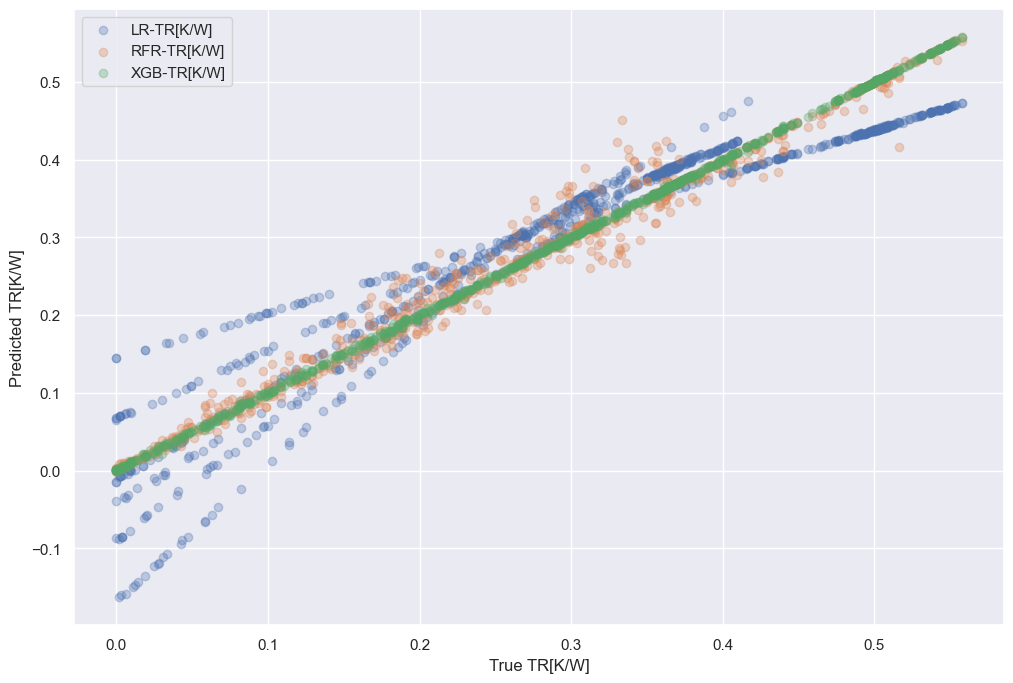

In [586]:
col = 'TR[K/W]'
plt.figure(figsize=(12,8))
plt.scatter(x=y_test[col], y=prediction_lr[col], label=f'LR-{col}', alpha=0.3)
plt.scatter(x=y_test[col], y=prediction_rfr[col], label=f'RFR-{col}', alpha=0.3)
plt.scatter(x=y_test[col], y=prediction_xgb[col], label=f'XGB-{col}', alpha=0.3)
plt.xlabel(f'True {col}')
plt.ylabel(f'Predicted {col}')
plt.legend()

plt.savefig(f'data/ml_TR_prediction.pdf')
plt.show()


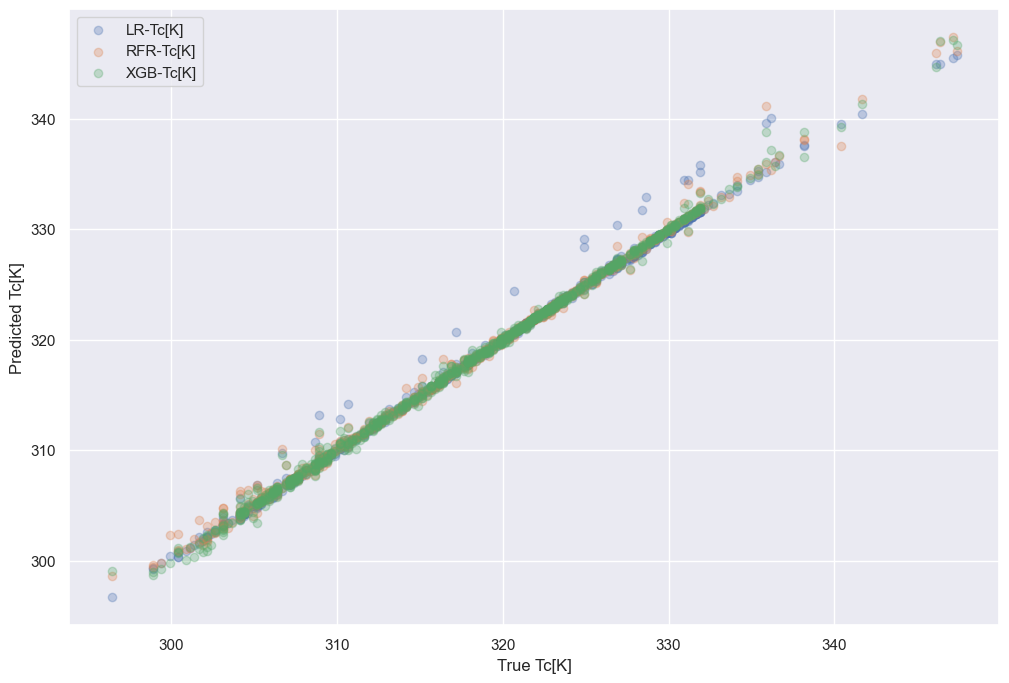

In [587]:
col = 'Tc[K]'
plt.figure(figsize=(12,8))
plt.scatter(x=y_test[col], y=prediction_lr[col], label=f'LR-{col}', alpha=0.3)
plt.scatter(x=y_test[col], y=prediction_rfr[col], label=f'RFR-{col}', alpha=0.3)
plt.scatter(x=y_test[col], y=prediction_xgb[col], label=f'XGB-{col}', alpha=0.3)
plt.xlabel(f'True {col}')
plt.ylabel(f'Predicted {col}')
plt.legend()


plt.savefig(f'data/ml_Tc_prediction.pdf')
plt.show()

# 2. TP Prediction

In [588]:
x = df[['Fluid', 'FR', 'Tc[K]', 'TR[K/W]']]
y = df[['Te[K]', 'P[bar]', 'Q[W]']]

In [589]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Data Pipeline

In [590]:
numeric_features = ['FR', 'Tc[K]', 'TR[K/W]']
categorical_features = ['Fluid']

numeric_transformer = make_pipeline(StandardScaler())
categorical_tranformer = make_pipeline(OneHotEncoder(sparse=False))

preprocessor = ColumnTransformer(
    transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_tranformer, categorical_features)
    ], verbose=True)


## LR Model

In [591]:
# Linear regression Model
model_lr = LinearRegression()

data_pipeline_lr = Pipeline(steps=[('Preprocessing', preprocessor),
                                ('LR_model', model_lr)], verbose=True)

# model training linear regression
data_pipeline_lr.fit(x_train, y_train)

[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ..... (step 1 of 2) Processing Preprocessing, total=   0.0s
[Pipeline] .......... (step 2 of 2) Processing LR_model, total=   0.0s


/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['FR', 'Tc[K]', 'TR[K/W]']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['Fluid'])],
                                   verbose=True)),
                ('LR_model', LinearRegression())],
         verbose=True)

## RFR Model

In [592]:
# RFR Model
model_rfr = RandomForestRegressor()

data_pipeline_rfr = Pipeline(steps=[('Preprocessing', preprocessor),
                                ('RFR_model', model_rfr)], verbose=True)

# model training RFR
data_pipeline_rfr.fit(x_train, y_train)

[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ..... (step 1 of 2) Processing Preprocessing, total=   0.0s


/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[Pipeline] ......... (step 2 of 2) Processing RFR_model, total=   0.4s


Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['FR', 'Tc[K]', 'TR[K/W]']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['Fluid'])],
                                   verbose=True)),
                ('RFR_model', RandomForestRegressor())],
         verbose=True)

## XGB Model

In [593]:
# XGB Model
model_xgb = xgb.XGBRegressor()

data_pipeline_xgb = Pipeline(steps=[('Preprocessing', preprocessor),
                                ('XGB_model', model_xgb)], verbose=True)

# model training
data_pipeline_xgb.fit(x_train, y_train)

[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.0s
[Pipeline] ..... (step 1 of 2) Processing Preprocessing, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing XGB_model, total=   0.2s


/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['FR', 'Tc[K]', 'TR[K/W]']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['Fluid'])],
                                   verbose=True)),
                ('XGB_model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsamp...
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))],
         verbose=True)

## Prediction

In [594]:
prediction_lr = ml_prediction(data_pipeline_lr, x_test, y_test)
prediction_rfr = ml_prediction(data_pipeline_rfr, x_test, y_test)
prediction_xgb = ml_prediction(data_pipeline_xgb, x_test, y_test)

## MAE and Accuracy by ML models

In [595]:
mae_lr = mae_ml(col='Te[K]', model='LR', prediction_df=prediction_lr, y_test=y_test)
mae_lr = mae_ml(col='Te[K]', model='RFR', prediction_df=prediction_rfr, y_test=y_test)
mae_lr = mae_ml(col='Te[K]', model='XGB', prediction_df=prediction_xgb, y_test=y_test)

Mean Absolute Error in Te[K] with a ML LR is : 3.1083 
Mean Accuracy in Te[K] with a ML LR is : 99.9356 [%]
Mean Absolute Error in Te[K] with a ML RFR is : 0.679 
Mean Accuracy in Te[K] with a ML RFR is : 100.0294 [%]
Mean Absolute Error in Te[K] with a ML XGB is : 0.7879 
Mean Accuracy in Te[K] with a ML XGB is : 100.0178 [%]


In [596]:
mae_lr = mae_ml(col='P[bar]', model='LR', prediction_df=prediction_lr, y_test=y_test)
mae_lr = mae_ml(col='P[bar]', model='RFR', prediction_df=prediction_rfr, y_test=y_test)
mae_lr = mae_ml(col='P[bar]', model='XGB', prediction_df=prediction_xgb, y_test=y_test)

Mean Absolute Error in P[bar] with a ML LR is : 0.0514 
Mean Accuracy in P[bar] with a ML LR is : 100.6326 [%]
Mean Absolute Error in P[bar] with a ML RFR is : 0.0179 
Mean Accuracy in P[bar] with a ML RFR is : 100.0715 [%]
Mean Absolute Error in P[bar] with a ML XGB is : 0.0168 
Mean Accuracy in P[bar] with a ML XGB is : 99.8691 [%]


In [597]:
mae_lr = mae_ml(col='Q[W]', model='LR', prediction_df=prediction_lr, y_test=y_test)
mae_lr = mae_ml(col='Q[W]', model='RFR', prediction_df=prediction_rfr, y_test=y_test)
mae_lr = mae_ml(col='Q[W]', model='XGB', prediction_df=prediction_xgb, y_test=y_test)

Mean Absolute Error in Q[W] with a ML LR is : 11.4244 
Mean Accuracy in Q[W] with a ML LR is : 99.3099 [%]
Mean Absolute Error in Q[W] with a ML RFR is : 4.2129 
Mean Accuracy in Q[W] with a ML RFR is : 100.4185 [%]
Mean Absolute Error in Q[W] with a ML XGB is : 4.5878 
Mean Accuracy in Q[W] with a ML XGB is : 100.2106 [%]


## Goodness of fit

In [598]:
goodness_of_fit(prediction_lr, y_test, model='LR',k=4)
goodness_of_fit(prediction_rfr, y_test, model='RFR',k=4)
goodness_of_fit(prediction_xgb, y_test, model='XGB',k=4)

R2 score by LR: 0.72507
R2-adjusted score by LR: 0.723911
R2 score by RFR: 0.914401
R2-adjusted score by RFR: 0.914041
R2 score by XGB: 0.917504
R2-adjusted score by XGB: 0.917156


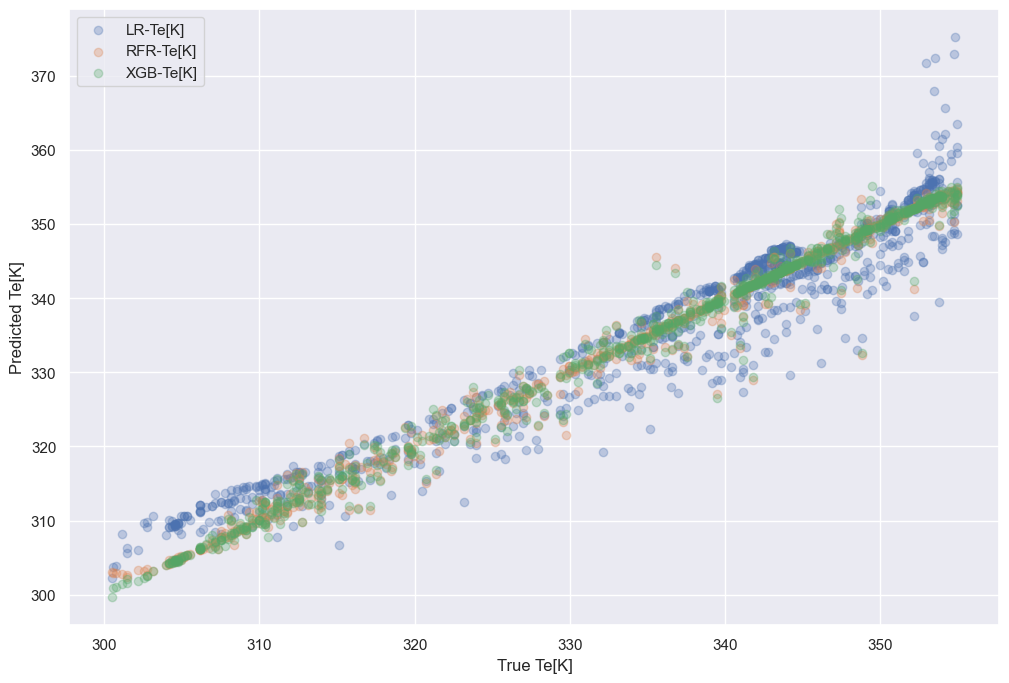

In [599]:
col = 'Te[K]'
plt.figure(figsize=(12,8))
plt.scatter(x=y_test[col], y=prediction_lr[col], label=f'LR-{col}', alpha=0.3)
plt.scatter(x=y_test[col], y=prediction_rfr[col], label=f'RFR-{col}', alpha=0.3)
plt.scatter(x=y_test[col], y=prediction_xgb[col], label=f'XGB-{col}', alpha=0.3)
plt.xlabel(f'True {col}')
plt.ylabel(f'Predicted {col}')
plt.legend()


plt.savefig(f'data/ml_Te_prediction.pdf')
plt.show()

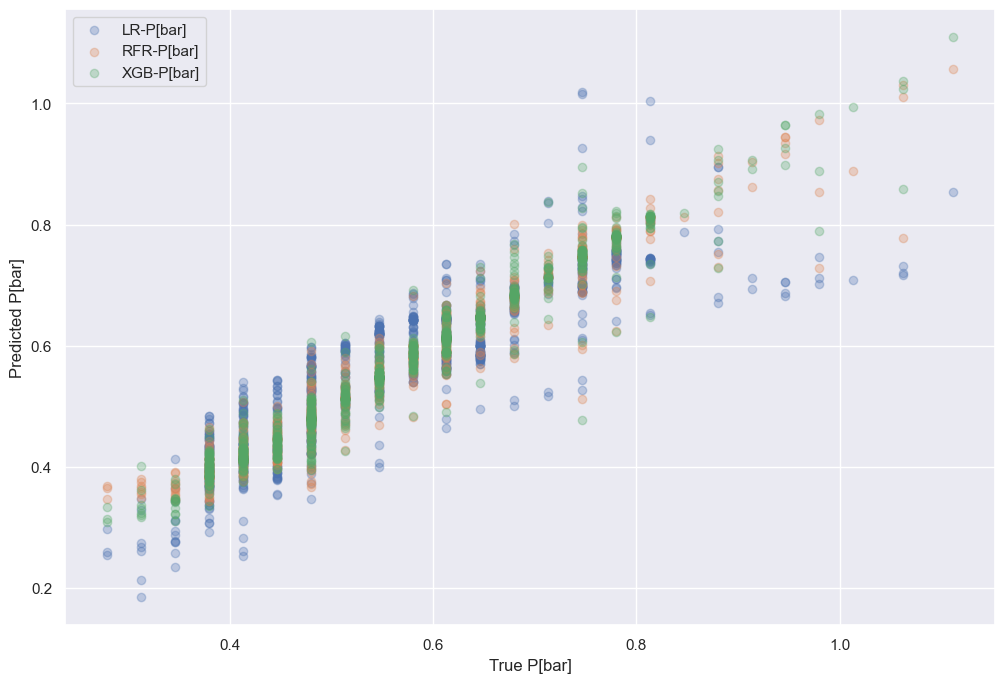

In [600]:
col = 'P[bar]'
plt.figure(figsize=(12,8))
plt.scatter(x=y_test[col], y=prediction_lr[col], label=f'LR-{col}', alpha=0.3)
plt.scatter(x=y_test[col], y=prediction_rfr[col], label=f'RFR-{col}', alpha=0.3)
plt.scatter(x=y_test[col], y=prediction_xgb[col], label=f'XGB-{col}', alpha=0.3)
plt.xlabel(f'True {col}')
plt.ylabel(f'Predicted {col}')
plt.legend()


plt.savefig(f'data/ml_P_prediction.pdf')
plt.show()

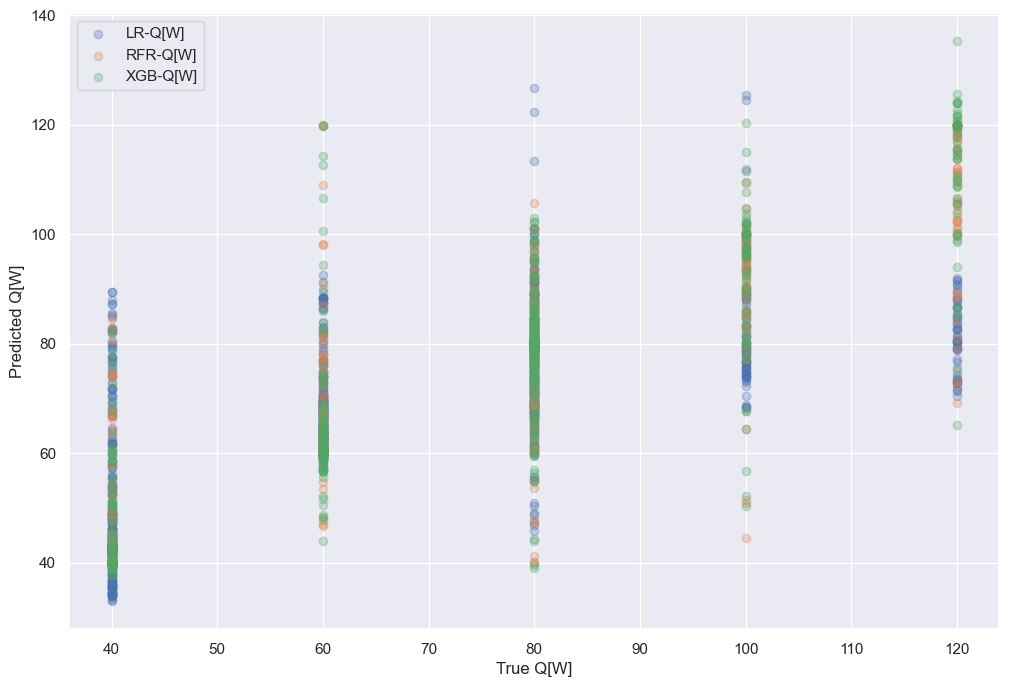

In [601]:
col = 'Q[W]'
plt.figure(figsize=(12,8))
plt.scatter(x=y_test[col], y=prediction_lr[col], label=f'LR-{col}', alpha=0.3)
plt.scatter(x=y_test[col], y=prediction_rfr[col], label=f'RFR-{col}', alpha=0.3)
plt.scatter(x=y_test[col], y=prediction_xgb[col], label=f'XGB-{col}', alpha=0.3)
plt.xlabel(f'True {col}')
plt.ylabel(f'Predicted {col}')
plt.legend()


plt.savefig(f'data/ml_Q_prediction.pdf')
plt.show()

## Prediction Example

In [602]:
lab = {'Fluid':['DI_Water', 'Al2O3_DI_Water'], 'FR':[50, 50], 'Tc[K]':[330, 330], 'TR[K/W]':[0.2, 0.2]}
lab_df = pd.DataFrame(data=lab)
lab_df

,Fluid,FR,Tc[K],TR[K/W]
0,DI_Water,50,330,0.2
1,Al2O3_DI_Water,50,330,0.2


In [603]:
lab_pred = data_pipeline_xgb.predict(lab_df)
lab_pred = pd.DataFrame(lab_pred)
lab_pred.columns = list(y_test.columns)
lab_pred

,Te[K],P[bar],Q[W]
0,348.665253,0.880088,99.108437
1,346.737335,0.646378,80.243675
